In [96]:
import numpy as np 
import matplotlib.pyplot as plt 
from sparse_rf.algs import *
from sparse_rf.modules import make_X, make_A
from sparse_rf.util import *
import sparse_rf.util.fns as fns 
import sparse_rf.util.polynomials as poly
from functools import partial
import random
import gc

import sys

In [217]:
def make_W(d, q, n=1, dist=normal):
    num_supports = comb(d, q)
    W = np.zeros((n*num_supports, d))
    inds = combinations(range(d), d-q)
    ds = set(range(d))
    inds_track = []
    for i in range(num_supports):
        ind = next(inds)
        inds_track.append(ds.difference(set(ind)))
        for j in range(n):
            w = dist(d)
            w[list(ind)] = 0
            W[i*n+j, :] = w
    return W, inds_track

In [245]:
data = np.loadtxt("airfoil_self_noise.dat")

ratio_train = 0.6
ratio_val = 0.2
ratio_test = 0.2
m = len(y)

X = data[:, :-1]
y = data[:, -1]
X_test = X[-int(m*ratio_test):, :]
y_test = y[-int(m*ratio_test):]

X_normalized = (X.T / np.linalg.norm(X.T, axis=0)).T

In [251]:
d = X.shape[-1]
q = 1
N = 10000
n = N//comb(d, q)
w_scale = 1/np.sqrt(q)
active = fourier

train_val_inds = np.arange(0, int(m*(ratio_train+ratio_val)))
train_inds = np.random.choice(train_val_inds, int(m*ratio_train), replace=False)
val_inds = np.setdiff1d(train_val_inds, train_inds)

y_train = y[train_inds]
y_val = y[val_inds]
np.linalg.norm(y_train)

3748.0043967049983

In [252]:
W, inds = make_W(d, q, n=n, dist=partial(normal, stdev=w_scale))
inds

[{4}, {3}, {2}, {1}, {0}]

In [253]:
X_train = X_normalized[train_inds, :]
X_val = X_normalized[val_inds, :]

A_train = make_A(X_train, W, active=active)
A_val = make_A(X_val, W, active=active)

In [254]:
c_l2 = min_l2(A_train, y_train)
np.linalg.norm(A_val@c_l2-y_val) / np.linalg.norm(y_val)

0.042764032580182965

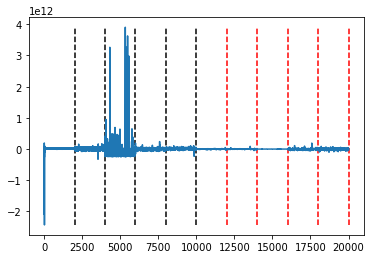

In [255]:
plt.plot(c_l2)
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+1), min(c_l2), max(c_l2), color="black", linestyles="--")
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+len(inds)+1), min(c_l2), max(c_l2), color="red", linestyles="--")

In [256]:
X_train = X[train_inds, :]
X_val = X[val_inds, :]
A_train = make_A(X_train, W, active=active)
A_val = make_A(X_val, W, active=active)

In [257]:
c_l1 = min_l1(A_train, y_train, eta=0)
np.linalg.norm(A_val@c_l1-y_val) / np.linalg.norm(y_val)

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001


0.036215759743631136

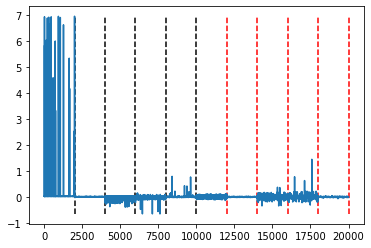

In [258]:
plt.plot(c_l1)
for i in range(len(inds)):
    plt.vlines((len(c_l1)//(2*len(inds)))*(i+1), min(c_l1), max(c_l1), color="black", linestyles="--")
for i in range(len(inds)):
    plt.vlines((len(c_l1)//(2*len(inds)))*(i+len(inds)+1), min(c_l1), max(c_l1), color="red", linestyles="--")

In [259]:
len(np.nonzero(c_l1)[0])

20000

In [260]:
X_test_l2 = (X_test.T / np.linalg.norm(X_test.T, axis=0)).T
A_test = make_A(X_test_l2, W, active=active)
np.linalg.norm(A_test@c_l2-y_test) / np.linalg.norm(y_test)

0.09169445557390325